In [95]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [96]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [97]:
df = pd.read_csv("../data/admissions.csv")
print(df.shape)
df.head(12).T

(400, 4)


,0,1,2,3,4,5,6,7,8,9,10,11
admit,0.00,1.00,1.0,1.00,0.00,1.0,1.00,0.00,1.00,0.00,0.0,0.00
gre,380.00,660.00,800.0,640.00,520.00,760.0,560.00,400.00,540.00,700.00,800.0,440.00
gpa,3.61,3.67,4.0,3.19,2.93,3.0,2.98,3.08,3.39,3.92,4.0,3.22
prestige,3.00,3.00,1.0,4.00,4.00,2.0,1.00,2.00,3.00,2.00,4.0,1.00


In [98]:
# check out the target variable
df['admit'].value_counts()

0    273
1    127
Name: admit, dtype: int64

In [99]:
df.isnull().sum().values

array([0, 2, 2, 1], dtype=int64)

In [100]:
df.dropna(inplace = True)

In [101]:
df.isnull().sum().values

array([0, 0, 0, 0], dtype=int64)

### 2. Examine the target

The target is the final column, `bankruptcy_label` (1 if the company went bankrupt within 5 years).

What is the distribution of the target?

In [102]:
df["admit"].value_counts(normalize=True)

0    0.68262
1    0.31738
Name: admit, dtype: float64

So it's an imbalanced dataset, only <4% of the companies went bankrupt within 5 years

### 3. Create a heatmap showing the correlations within your features

It's generally a good idea to see how your features correlate to each other, to identify columns that perhaps encode the same information. We'll do this by calculating the correlation matrix (how every column correlates with every other) and inspect it visually as a heatmap.

#### 3. a. Get a correlation matrix of your features (hint: there's a built in `pandas` function for that!

In [103]:
corr_matrix = df.drop("admit", axis=1).corr()
corr_matrix.head(2)

,gre,gpa,prestige
gre,1.000000,0.382408,-0.124533
gpa,0.382408,1.000000,-0.060976


### 4. Look at the distribution of your variables for bankrupt vs. non-bankrupt companies

We're looking for cases where the distribution of a feature is different for bankrupt companies, suggesting that it would be a good feature to separate the classes.

You could start by comparing the average value of each feature for bankrupt vs. non-bankrupt companies, or as a bonus plot the actual distribution (using histograms, box plots or similar).

In [104]:
# columns to look at are all but the last one
feature_cols = df.columns

# group by the target and average each feature column
# and transpose using `.T` to see them side-by-side rather than above-below
# and rename to give columns meaningful names
feature_means = (
    df
        .groupby("admit")
        [feature_cols]
        .mean()
        .T
        .rename(columns={0:"denied",
                         1:"accepted"})
)

feature_means.head()

admit,denied,accepted
admit,0.000000,1.000000
gre,573.579336,618.571429
gpa,3.347159,3.489206
prestige,2.645756,2.150794


In [107]:
# calculate % diff between averages
# and sort by this column to see the ones that differ the most
# between bankrupt and non-bankrupt companies

feature_means["diff"] = (feature_means["denied"] - feature_means["accepted"]) / feature_means["accepted"]
feature_means.sort_values("diff", ascending=False).head(10)

admit,denied,accepted,diff
prestige,2.645756,2.150794,0.230130
gpa,3.347159,3.489206,-0.040711
gre,573.579336,618.571429,-0.072735
admit,0.000000,1.000000,-1.000000


In [109]:
features_to_use

['gre', 'gpa', 'prestige']

In [110]:
# there's a lot of imbalance with bankruptcy
df["admit"].value_counts()

0    271
1    126
Name: admit, dtype: int64

# Part 2 - Prediction

### 1. Using the features you selected above, create training and test sets

Ensure that both your training and test sets have the same distribution of bankrupt/non-bankrupt companies. You can use a specific parameter when splitting your data to achieve this.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# drop missing values for features only
X = df.dropna(subset=features_to_use)[features_to_use]
y = df.dropna(subset=features_to_use)["admit"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y # stratify to ensure train/test have ~4% bankrupt companies
                                                   )

print(len(X_train), len(y_train), len(X_test), len(y_test))

277 277 120 120


In [112]:
y_train.value_counts(normalize=True)

0    0.68231
1    0.31769
Name: admit, dtype: float64

In [113]:
y_test.value_counts(normalize=True)

0    0.683333
1    0.316667
Name: admit, dtype: float64

### 2. Choose an appropriate metric for evaluating your predictions

Think about:

- the problem itself: is it classification (binary? multi-class?)/regression?
- the distribution of your target: does this change which metrics are appropriate?

This is a binary classification problem with an imbalanced dataset. We can't use accuracy because of the imbalance, because even if we predicted "no bankruptcy" in all cases, we'd get 96% accuracy!

F1 score or ROC-AUC are more appropriate metrics.

### 3. Train a predictive model

- Think about best practices:
    - Only train using the training set
    - Use cross-validation to get a better estimate of performance on unseen data
    - Use grid search to optimise your models' hyperparameters

In [114]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter=20000)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=20000, solver='newton-cg')

In [115]:
# Predicting on the test data
pred_test = lr.predict(X_test)

In [116]:
lr.coef_

array([[ 0.00321119,  0.7155019 , -0.42287144]])

In [118]:
lr.intercept_

array([-3.35801144])

In [122]:
def predict(gpa, gre, prestige):
    return (gre*0.00321119) + (gpa*0.7155019) - (prestige*0.42287144) - 3.35801144

def update_output_div(gpa, gre, prestige):
    value = predict(float(gpa), float(gre), float(prestige))
    if (value < 0.5):
        return f"Try a different college. ({value})"
    else :
        return f"Welcome to college! ({value})"
update_output_div('3','4','5')

'Try a different college. (-3.3130181799999994)'

In [49]:
pred_test

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

In [50]:
y_test

385    0
218    0
160    0
90     0
282    0
359    0
12     1
338    0
350    1
46     1
317    1
177    1
65     0
4      0
394    1
35     0
110    0
49     0
356    0
337    0
75     0
348    0
155    1
398    0
169    0
122    0
213    0
292    0
105    1
154    0
36     0
309    0
40     0
107    0
332    0
290    1
321    0
283    0
148    1
281    0
395    0
253    1
167    0
375    0
379    0
145    0
106    1
269    0
341    1
193    0
121    1
344    0
216    0
247    0
351    0
190    1
244    0
391    1
295    0
371    1
56     0
227    0
162    1
113    0
42     1
296    0
229    1
143    0
353    0
55     1
339    1
237    0
335    1
300    0
163    0
390    1
14     1
331    0
255    0
228    0
387    0
19     1
189    0
182    0
82     0
13     0
325    0
210    0
222    1
264    1
252    1
333    0
184    0
125    0
365    0
225    1
53     1
388    0
307    0
181    0
368    0
287    1
151    0
297    0
231    0
383    0
267    1
302    1
31     0
250    0
304    0
1

In [51]:
#Calculating and printing the f1 score 
accuracy_test = metrics.accuracy_score(y_test, pred_test)
print('The accuracy score for the testing data:', accuracy_test)
f1_test = metrics.f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The accuracy score for the testing data: 0.5666666666666667
The f1 score for the testing data: 0.44680851063829785


In [52]:
#Plotting the confusion matrix
metrics.confusion_matrix(y_test, pred_test)

array([[47, 35],
       [17, 21]], dtype=int64)

In [ ]:
import numpy as np

# this cell will take a while.
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)


Text(0.5, 1.0, 'Scoring for different class weights')

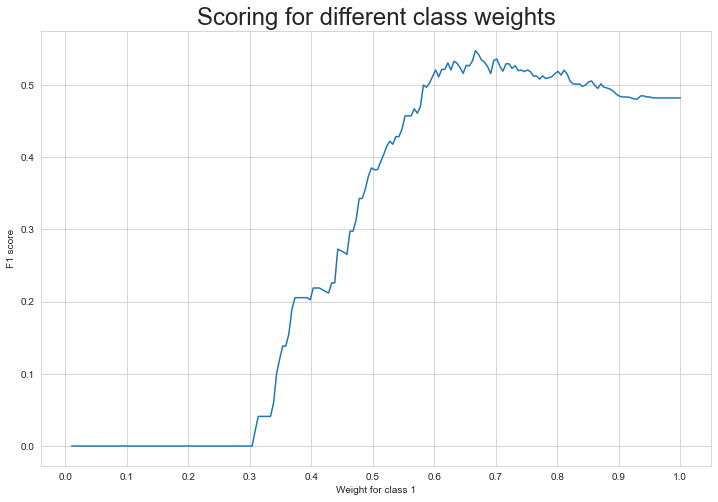

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plotting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)


In [57]:
# the optimal class weights:
gridsearch.best_params_

{'class_weight': {0: 0.3333165829145729, 1: 0.6666834170854271}}

In [58]:
# refit the model:
lr2 = LogisticRegression(solver='newton-cg', 
                        class_weight={0: 0.3333165829145729, 1: 0.6666834170854271})

In [91]:
lr2.fit(X_train, y_train)
print(lr2.predict([[4, 800, 1]]))
pickle.dump(lr2, open('model', 'wb'))

[1]


In [59]:
# make a confusion matrix
y_pred_lr_train = gridsearch.best_estimator_.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_lr_train)

array([[127,  62],
       [ 31,  57]], dtype=int64)

In [60]:
# predict on the testing data
y_preds = gridsearch.best_estimator_.predict(X_test)
print(len(y_test))
print(len(y_preds))

120
120


In [61]:
# score your model
print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

0.5833333333333334
0.38461538461538464
0.4444444444444444


In [81]:
X_train

,gre,gpa,prestige
100,340.0,3.15,3.0
71,300.0,2.92,4.0
136,560.0,3.33,4.0
248,680.0,3.64,3.0
102,380.0,3.33,4.0
37,520.0,2.90,3.0
257,620.0,3.95,3.0
291,800.0,2.78,2.0
217,460.0,3.64,1.0
259,640.0,3.81,2.0


In [83]:
{'gpa':4, 'gre':5, 'prestige':1}

{'gpa': 4, 'gre': 5, 'prestige': 1}

High accuracy - but only because of imbalance classes!

### 4. Evaluate your models on the *training* set

Go deeper than the single metric you used for training. Try showing the confusion matrix for both models - what can you see?

In [62]:
from sklearn.metrics import confusion_matrix

y_pred_lr_train = gridsearch.best_estimator_.predict(X_train)
confusion_matrix(y_train, y_pred_lr_train)

array([[127,  62],
       [ 31,  57]], dtype=int64)

In [80]:
import pickle
pickle.dump(gridsearch.best_estimator_, open('model', 'wb'))

It's clear that the model is just predicting "not bankrupt" for pretty much everything!

# Part 3 - Improvements

Time to improve your models. There are many different things you can do here including:

- choosing more/different features
- trying to tune more hyperparameters (if they exist)
- trying a third model
- tuning other aspects of the prediction process (e.g. changing the cutoff for predicting 1 instead of 0 from the default of 0.5, that is: if your model predicts a company is 50% or more likely to be bankrupt it will predict "bankrupt". Changing this threshold may help improve its performance)

Further reading is available for example in this excellent article [Learning from Imbalanced Classes](https://www.svds.com/learning-imbalanced-classes/)

### 1. Try something to improve your best performing model from above

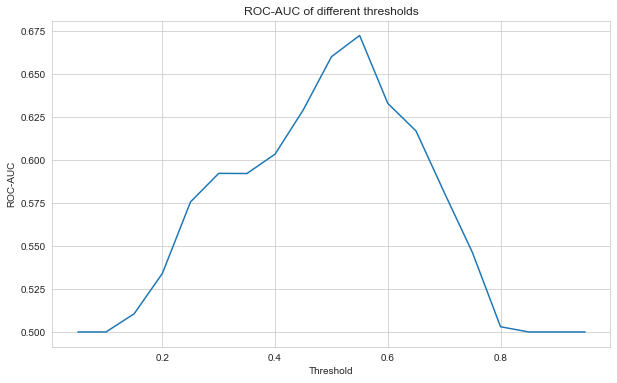

In [63]:
from sklearn.metrics import roc_auc_score

# let's try changing the decision threshold from 0.5
# define a function to try a threshold and return the AUC
def try_threshold(model, X, y, threshold):
    # predict probability of bankruptcy not just 0 or 1
    predicted_proba = model.predict_proba(X)
    
    # only return 1 if probability over chosen threshold
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    
    # evaluate these predictions
    return roc_auc_score(y, predicted)

thresholds_to_try = np.arange(0.05, 1, 0.05)
scores = []

for t in thresholds_to_try:
    scores.append(try_threshold(gridsearch.best_estimator_, X_train, y_train, t))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds_to_try, scores)

ax.set(title="ROC-AUC of different thresholds",
       xlabel="Threshold",
       ylabel="ROC-AUC")

plt.show()

Because the model is never "confident" in non-bankrupt predictions, changing the threshold seems to improve our score.

Try our predictions with a much lower threshold:

In [64]:
proba = gridsearch.best_estimator_.predict_proba(X_test)
y_preds = (proba[:,1] >= 0.5).astype('int')

print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

0.5833333333333334
0.38461538461538464
0.4444444444444444


That looks a little healthier.

## Try a different type of model

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
# these parameters are from gridsearch
rf_model= RandomForestClassifier(max_depth=3, min_samples_leaf=25, n_estimators=91)

In [67]:
# fit
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=25, n_estimators=91)

In [68]:
# predict
y_preds=rf_model.predict(X_test)

In [69]:
# score your model
print(metrics.accuracy_score(y_test, y_preds))
print(metrics.precision_score(y_test, y_preds))
print(metrics.f1_score(y_test, y_preds))

0.6833333333333333
0.5
0.05


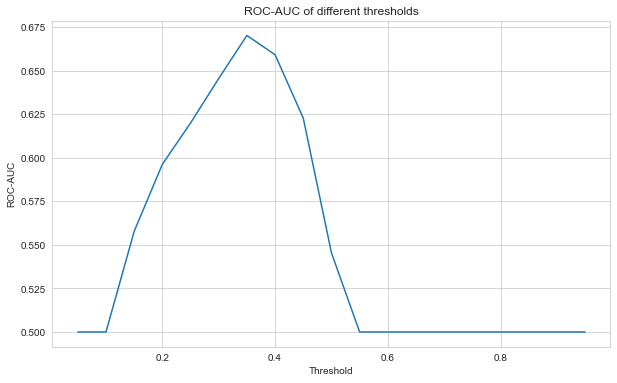

In [70]:
from sklearn.metrics import roc_auc_score

# let's try changing the decision threshold from 0.5
# define a function to try a threshold and return the AUC
def try_threshold(model, X, y, threshold):
    # predict probability of bankruptcy not just 0 or 1
    predicted_proba = model.predict_proba(X)
    
    # only return 1 if probability over chosen threshold
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    
    # evaluate these predictions
    return roc_auc_score(y, predicted)

thresholds_to_try = np.arange(0.05, 1, 0.05)
scores = []

for t in thresholds_to_try:
    scores.append(try_threshold(rf_model, X_train, y_train, t))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds_to_try, scores)

ax.set(title="ROC-AUC of different thresholds",
       xlabel="Threshold",
       ylabel="ROC-AUC")

plt.show()

In [71]:
# Try our predictions with a much lower threshold:
proba = rf_model.predict_proba(X_train)
y_pred_rf_v2 = (proba[:,1] >= 0.05).astype('int')
confusion_matrix(y_train, y_pred_rf_v2)

array([[  0, 189],
       [  0,  88]], dtype=int64)

In [72]:
# and now the testing data
proba = rf_model.predict_proba(X_test)
y_pred_rf_v2 = (proba[:,1] >= 0.05).astype('int')
cm = confusion_matrix(y_test, y_pred_rf_v2)
cm

array([[ 0, 82],
       [ 0, 38]], dtype=int64)

In [73]:
tn = cm[0][0]
tp = cm[1][1]
fn = cm[1][0]
fp = cm[0][1]

In [74]:
# Precision = TP / (TP+FP)
round(tp / (tp + fp), 3)

0.317

In [75]:
# Recall = TP / (TP+FN)
round(tp / (tp + fn), 3)

1.0